In [1]:
!pip install -q crewai langchain langchain-core langchain_groq tabulate matplotlib

In [2]:
!pip install -q matplotlib

In [11]:
from crewai import Agent, Task , Crew

In [12]:
from langchain_groq import ChatGroq
apikey=""
llm=ChatGroq(model="llama3-70b-8192",api_key=apikey)

In [13]:
import pandas as pd 
df=pd.read_csv("/home/balamurali/EDA_Automation/data/StudentsPerformance_with_headers.csv")

In [14]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
agent = create_pandas_dataframe_agent(llm, df, verbose=False,allow_dangerous_code=True)

In [15]:
def csv_agent(agent,query):
    return agent.invoke(query)["output"]

In [16]:
from langchain.tools import StructuredTool
price_tool = StructuredTool.from_function(func=lambda input: csv_agent(agent,input),
                                              name='Data Agent',
                                              description='This function will help you to answer any questions related to the data with input passed to it')

In [17]:
data_description="""Student ID
1- Student Age (1: 18-21, 2: 22-25, 3: above 26)
2- Sex (1: female, 2: male)
3- Graduated high-school type: (1: private, 2: state, 3: other)
4- Scholarship type: (1: None, 2: 25%, 3: 50%, 4: 75%, 5: Full)
5- Additional work: (1: Yes, 2: No)
6- Regular artistic or sports activity: (1: Yes, 2: No)
7- Do you have a partner: (1: Yes, 2: No)
8- Total salary if available (1: USD 135-200, 2: USD 201-270, 3: USD 271-340, 4: USD 341-410, 5: above 410)
9- Transportation to the university: (1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other)
10- Accommodation type in Cyprus: (1: rental, 2: dormitory, 3: with family, 4: Other)
11- Mothersâ€™ education: (1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.)
12- Fathersâ€™ education: (1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.)
13- Number of sisters/brothers (if available): (1: 1, 2:, 2, 3: 3, 4: 4, 5: 5 or above)
14- Parental status: (1: married, 2: divorced, 3: died - one of them or both)
15- Mothersâ€™ occupation: (1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other)
16- Fathersâ€™ occupation: (1: retired, 2: government officer, 3: private sector employee, 4: self-employment, 5: other)
17- Weekly study hours: (1: None, 2: <5 hours, 3: 6-10 hours, 4: 11-20 hours, 5: more than 20 hours)
18- Reading frequency (non-scientific books/journals): (1: None, 2: Sometimes, 3: Often)
19- Reading frequency (scientific books/journals): (1: None, 2: Sometimes, 3: Often)
20- Attendance to the seminars/conferences related to the department: (1: Yes, 2: No)
21- Impact of your projects/activities on your success: (1: positive, 2: negative, 3: neutral)
22- Attendance to classes (1: always, 2: sometimes, 3: never)
23- Preparation to midterm exams 1: (1: alone, 2: with friends, 3: not applicable)
24- Preparation to midterm exams 2: (1: closest date to the exam, 2: regularly during the semester, 3: never)
25- Taking notes in classes: (1: never, 2: sometimes, 3: always)
26- Listening in classes: (1: never, 2: sometimes, 3: always)
27- Discussion improves my interest and success in the course: (1: never, 2: sometimes, 3: always)
28- Flip-classroom: (1: not useful, 2: useful, 3: not applicable)
29- Cumulative grade point average in the last semester (/4.00): (1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49)
30- Expected Cumulative grade point average in the graduation (/4.00): (1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49)
31- Course ID
32- OUTPUT Grade (0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA)"""

In [18]:
data_researcher=Agent(role='Senior Data Researcher',goal='Create Questions for Data Analysis which can provide valuable insights',
                        backstory="""You are a Senior Data Researcher at a leading data company.
                    You are expert at performing Exploratory data anlaysis by asking the righ questions""",
                      allow_delegation=False,verbose=True,llm=llm)

data_analyst=Agent(role='Senior Data Analyst',goal='Answer the questions asked by the data researcher by using the tool',
                     backstory="""
                            You are a software engineer that specializes in answering the questions asked by the data researcher. 
                            You are expert at providing accurate results so that we can derive as much as insights from the data""",
                        allow_delegation=False,verbose=True,llm=llm,tools=[price_tool])
chief_da=Agent(role='Chief Data Analyst',goal='Try to gather all the insights based on the context provided and create a report for the data analysis',
  		             backstory="""You feel that everyone always don't do a perfect job, so you are super dedicate to make high quality report.""",
		             allow_delegation=False,verbose=True,llm=llm)

In [19]:
from textwrap import dedent
ques_task=Task(description=dedent("""
            You will create a list of questions to be answered in exploratory data analysis based on the data description:
			Data Description
			------------
        	{context}

			Your Final answer must be a list of 3 questions needed to be answered to gather meaningful insights, only the questions and nothing else.

            ###Question 1
            ###Question 2
            
            """),
			agent=data_researcher,
            expected_output="A list of questions"
		)

ans_task=Task(description=dedent("""
			You are helping in answering the question provided to you,
            
            Instructions to use the tool:

            1.Query should be passed in key value pair
            2. Key should be "input"
            3. Value should be the question
            
            These are the Question:
			Questions
			------------
            ###Question 1
            ###Question 2
            
			Using the tool available to you, you can answer to the question provided to you.
            Avoid irrelevant answers and do not provide any code in the answers.

			Your Final answer must be in the format given below:
            
            ###Question 1
            Answer
            ###Question 2 
            Answer
			"""),
			agent=data_analyst,
            expected_output="Answers to the question provided"
		)
summarize_task=Task(description=dedent("""
						Write a 4-5 point data analysis report with covering all meaningful insights"""),
			agent=chief_da,
            expected_output="A report for the data analysis"
		)

2024-07-09 16:09:20,274 - 140262391018112 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [2024-07-09 16:09:20][DEBUG]: == Working Agent: Senior Data Researcher
 [2024-07-09 16:09:20][INFO]: == Starting Task: 
            You will create a list of questions to be answered in exploratory data analysis based on the data description:
			Data Description
			------------
        	Student ID
1- Student Age (1: 18-21, 2: 22-25, 3: above 26)
2- Sex (1: female, 2: male)
3- Graduated high-school type: (1: private, 2: state, 3: other)
4- Scholarship type: (1: None, 2: 25%, 3: 50%, 4: 75%, 5: Full)
5- Additional work: (1: Yes, 2: No)
6- Regular artistic or sports activity: (1: Yes, 2: No)
7- Do you have a partner: (1: Yes, 2: No)
8- Total salary if available (1: USD 135-200, 2: USD 201-270, 3: USD 271-340, 4: USD 341-410, 5: above 410)
9- Transportation to the university: (1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other)
10- Accommodation type in Cyprus: (1: rental, 2: dormitory, 3: with family, 4: Other)
11- Mothersâ€™ education: (1: primary school, 2: secondary school, 3: high sch

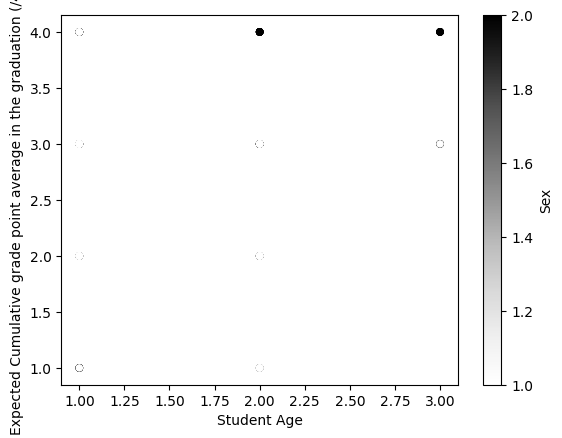

 

The relationship between the student's age and their expected cumulative grade point average in graduation varies by sex. For Sex=1, there is a negative correlation (-0.201351), suggesting that older students tend to have lower expected cumulative grade point averages. For Sex=2, there is a positive correlation (0.218867), suggesting that older students tend to have higher expected cumulative grade point averages.

Thought:
I need to answer the questions provided using the Data Agent tool. 

Let's start with Question 1.

Thought: I need to understand the relationship between student's age and expected cumulative grade point average in graduation, and how it varies by sex.

Action: Data Agent
Action Input: {"input": "What is the relationship between the student's age and their expected cumulative grade point average in graduation, and how does it vary by sex?"} 

I tried reusing the same input, I must stop using this action input. I'll try something else instead.



Thought: I need t

In [20]:
crew = Crew(
	agents=[
		data_researcher,
		data_analyst,
		chief_da
	],
	tasks=[
		ques_task,
		ans_task,
		summarize_task,  
	],
	verbose=True
)

result = crew.kickoff(inputs=({"context": data_description}))

In [21]:
print(result)

**Data Analysis Report**

The following report presents the findings from the analysis of student data, focusing on the relationships between various factors and their impact on academic performance.

**Insight 1: Correlation between Age and Expected Cumulative GPA**

The correlation between student's age and expected cumulative grade point average in graduation is -0.201351 for sex 1 and 0.218867 for sex 2. This suggests that there is a weak negative correlation between age and expected cumulative GPA for sex 1, indicating that older students tend to have slightly lower expected GPAs. In contrast, there is a weak positive correlation between age and expected cumulative GPA for sex 2, suggesting that older students tend to have slightly higher expected GPAs.

**Insight 2: Comparison of Mean Cumulative GPA by Living Arrangement**

The mean cumulative grade point average for students living in dormitories is 3.1176, and for students living with their families is 3.3673. This indicates th